In [73]:
%load_ext autoreload
%autoreload 1
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
figures_path = "../../../Google Drive/Brown/Physics/Thesis/Diamond NV Spin Tomography/Writing/Presentation_Delft/Figures/Decoherence/"
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [94]:
diamond = learning.load_obj("diamonds/diamond_21")

In [95]:
N = 64
tau = analysis.choose_tau_params(64)
def data_func(N, tau, noise_level = .02): #put the noise at .02
    data = analysis.calc_M(diamond["A"], diamond["B"], N, omega_larmor, tau)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise
data = data_func(N, tau, 0)

In [96]:
dip_inds, windows = analysis.find_resonances(data, fit_dips_below = 0)
dii = 100

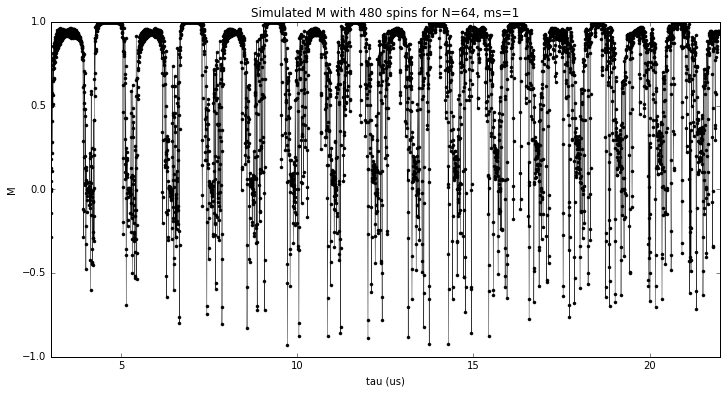

In [97]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,22], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
ax.plot(tau * 1e6, data, '.-k', lw=0.4, label = 'M')
#plt.axvline(tau[dip_inds[dii]] * 1e6, color='green')
plt.title("Simulated M with " + str(len(diamond["A"])) + " spins for N=" + str(N) +", ms=" + str(ms))
plt.show()

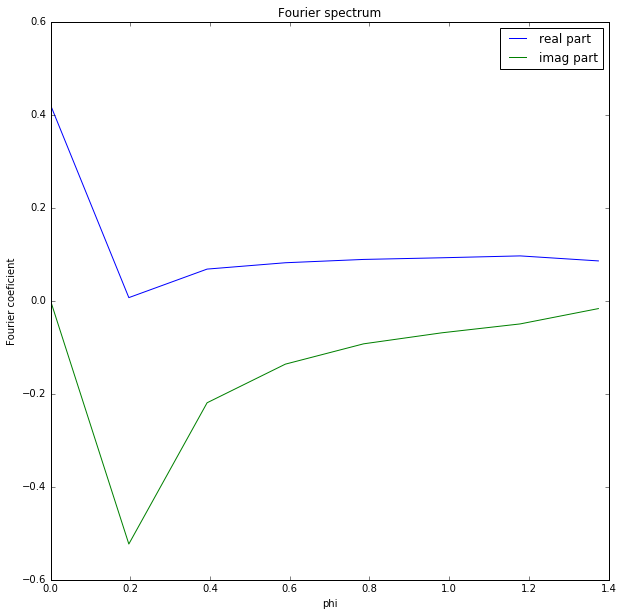

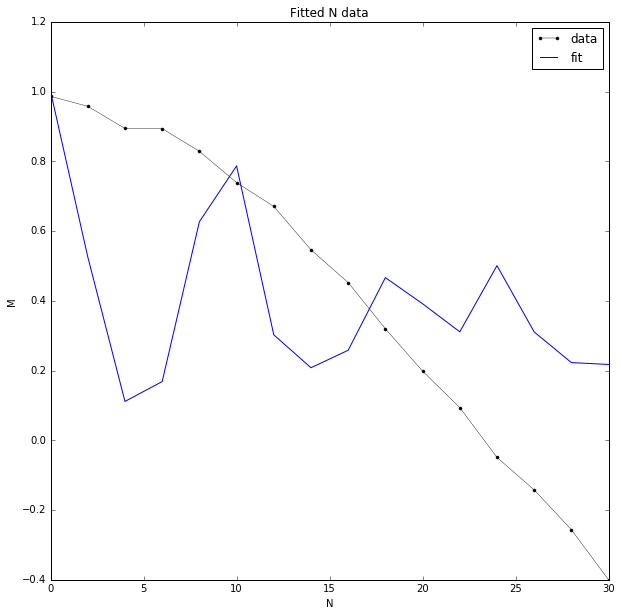

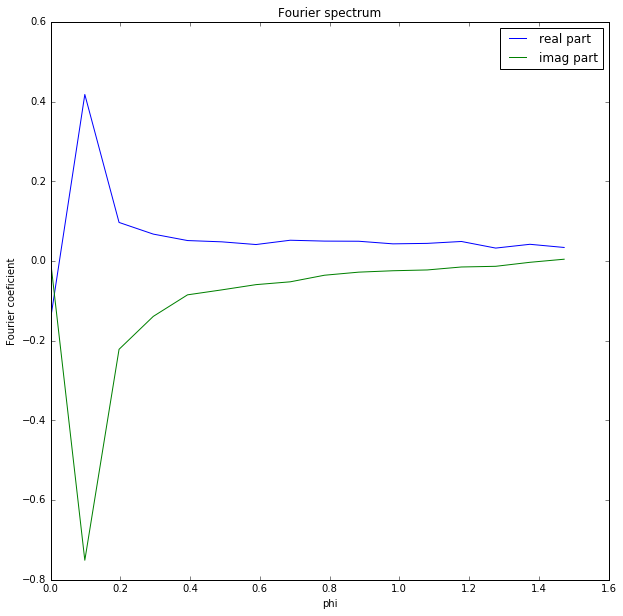

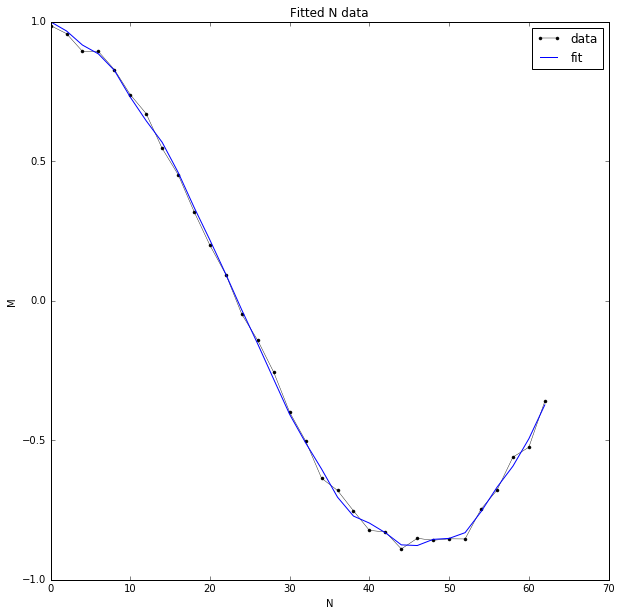

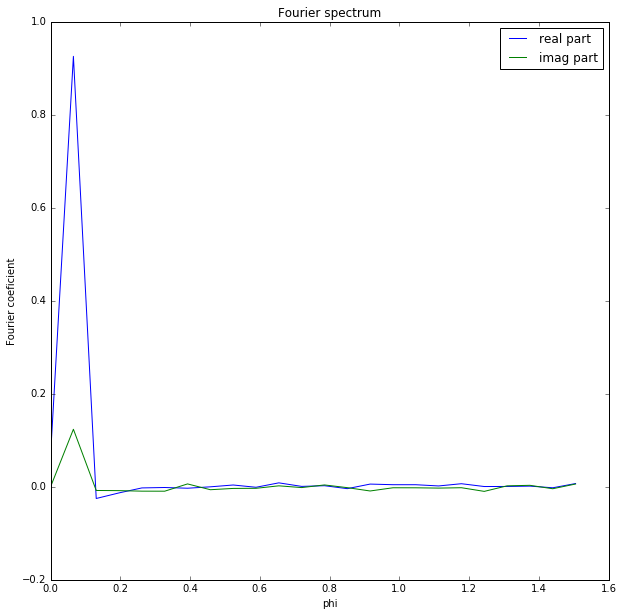

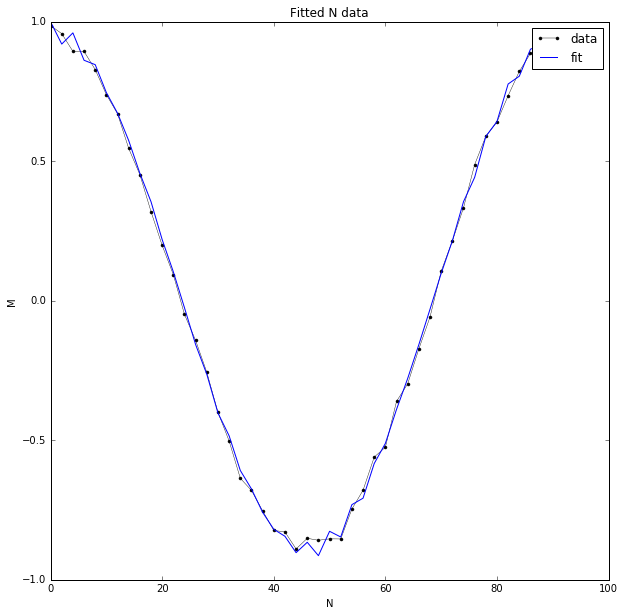

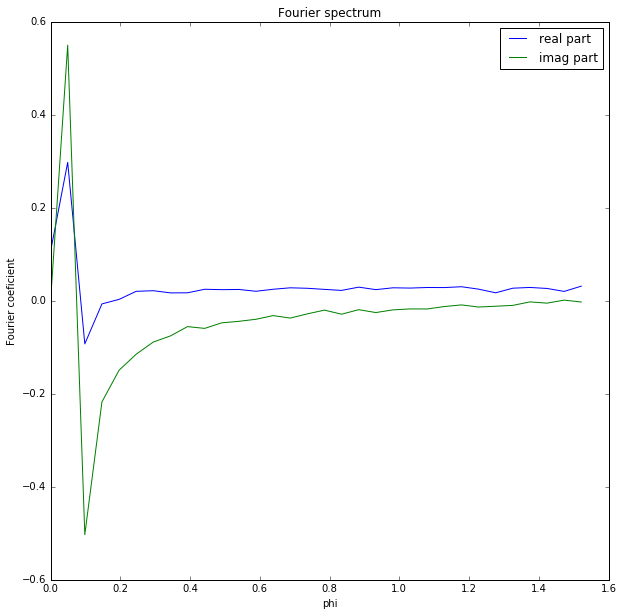

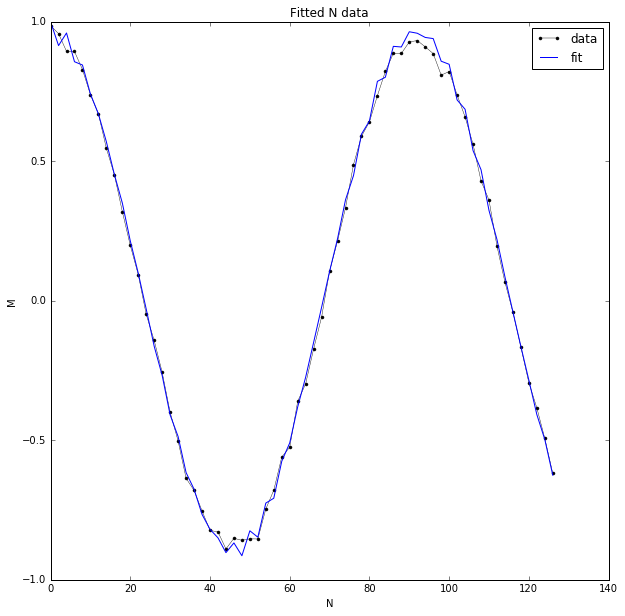

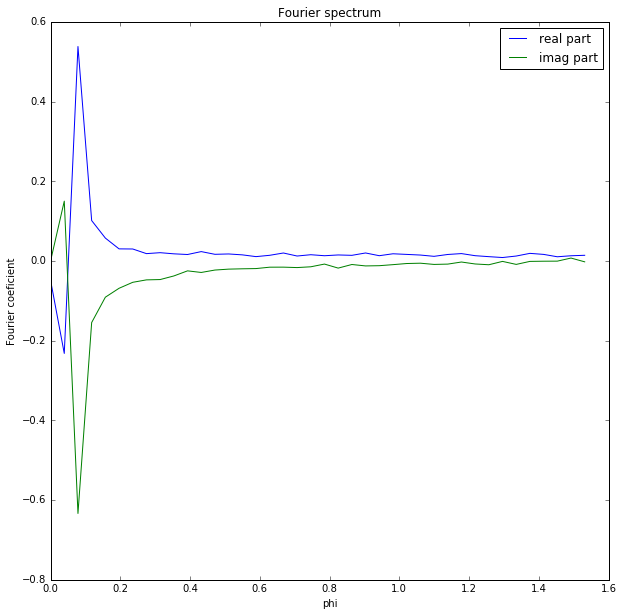

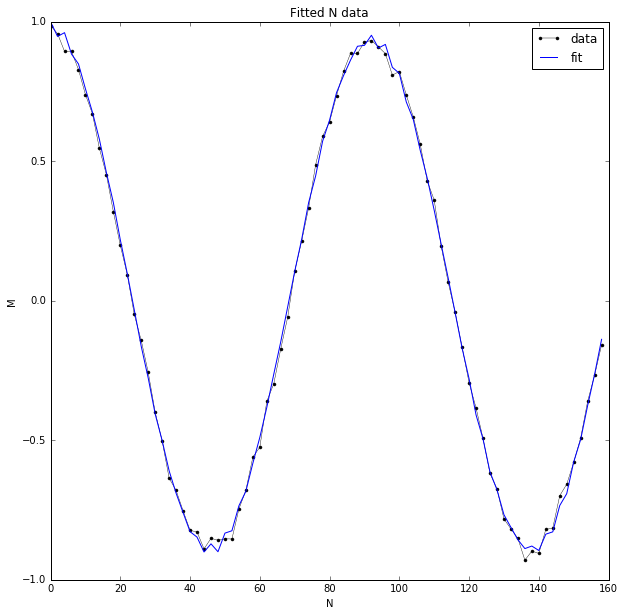

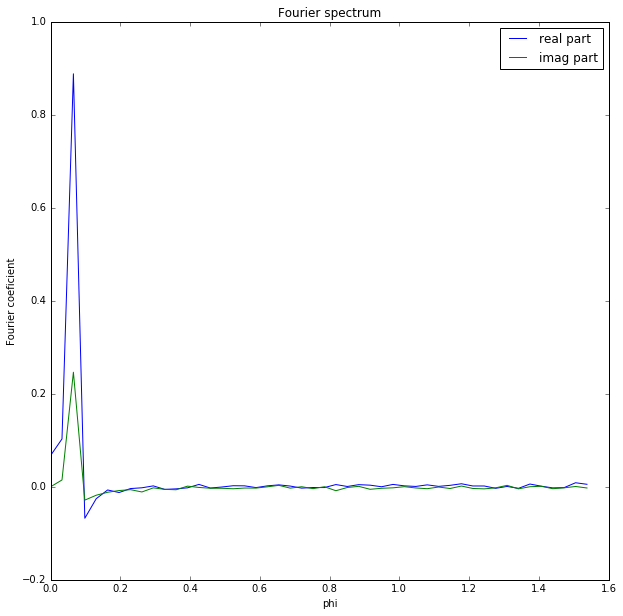

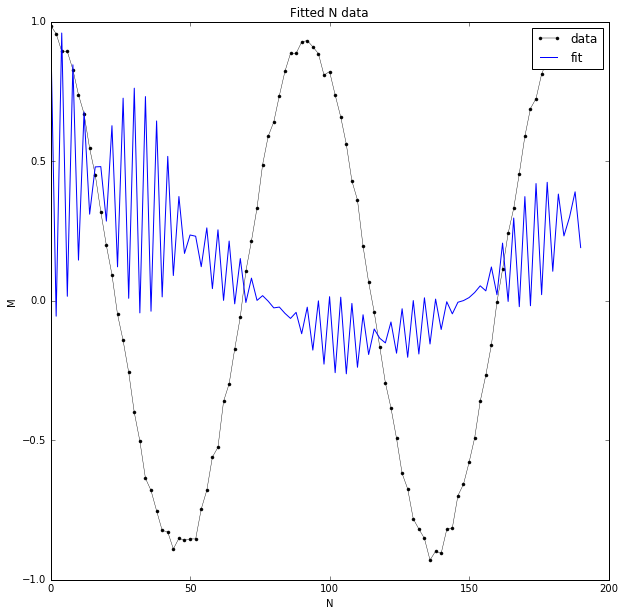

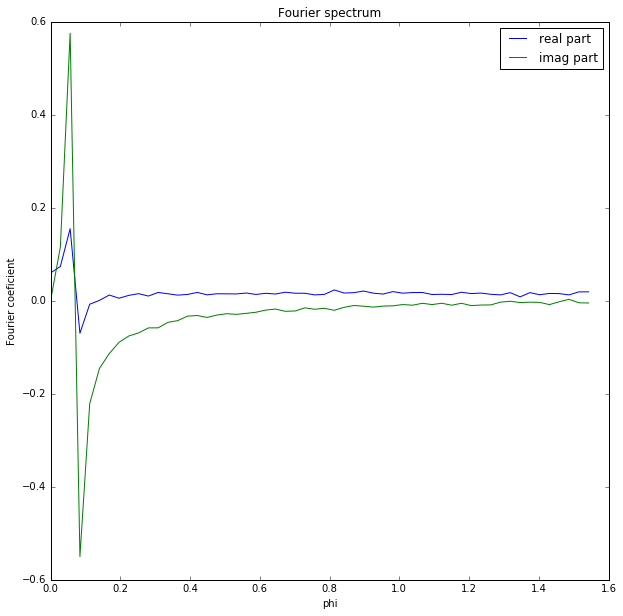

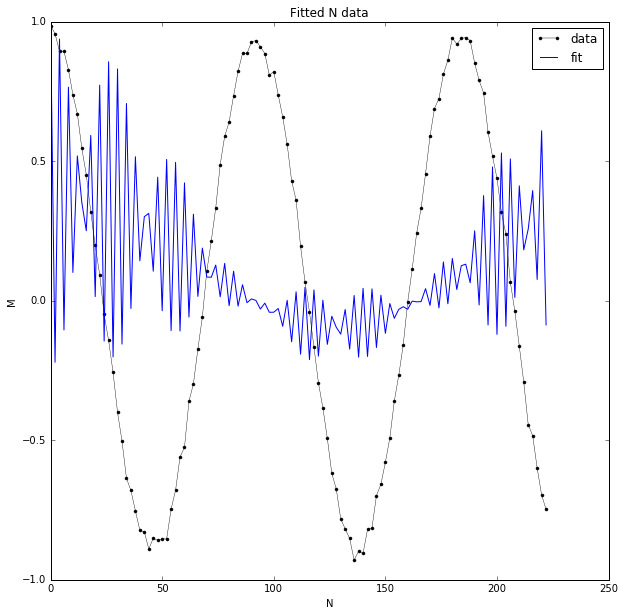

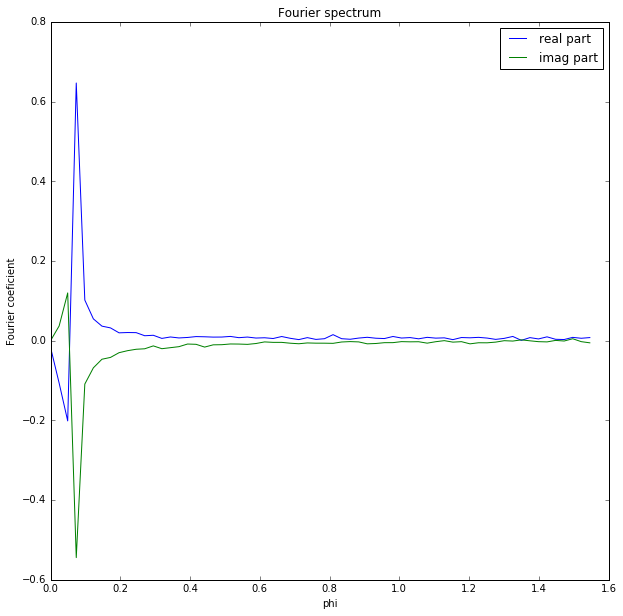

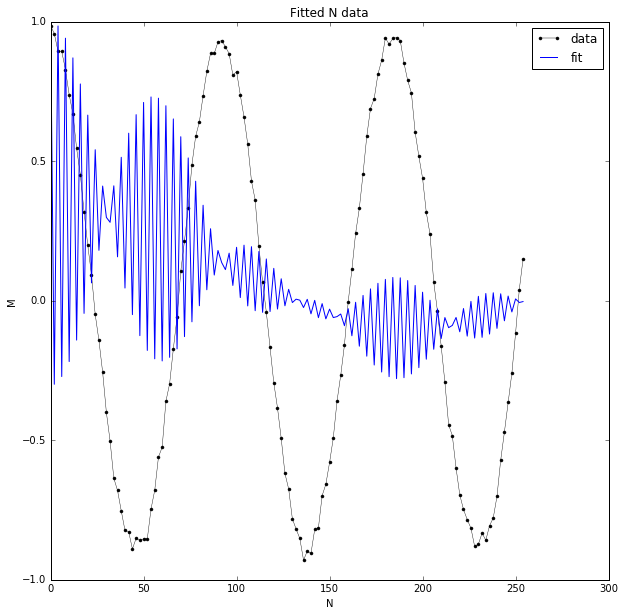

best before final pass:  4
answer before final pass:  [ 1.93064073  0.04447079  0.04352824] [ 0.06842506  1.44150871  0.03408434]


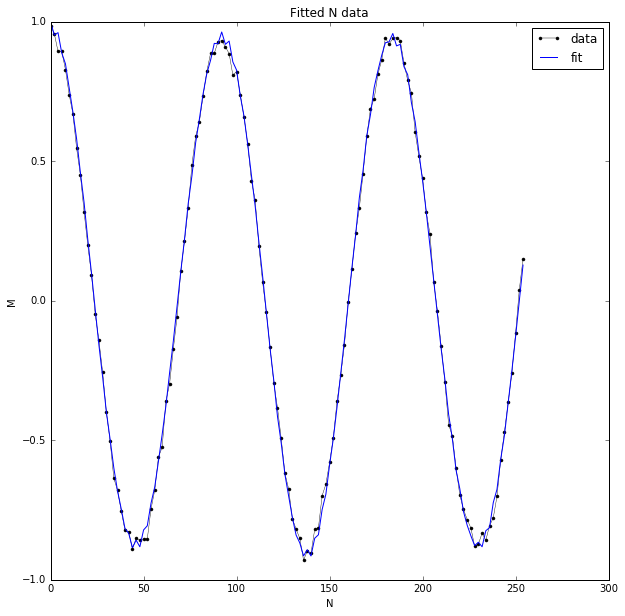

best overall:  8
[0.6482398836516281, 0.00077740128573040152, 0.0010589045338852579, 0.00084847000186665704, 0.00064525603922416458, 0.58306302212233874, 0.55738825123457947, 0.49033989739510841, 0.00053013810887533148]
res_tau:  1.25465777603e-05
scaled_error <= error_tol:  True
scaled_error:  0.000530138108875
xs, phis, scaled_error:  [ 1.92647839  0.04806047  0.03923024] [ 0.06840844  0.04590726  1.437869  ] 0.000530138108875


In [8]:
spin_dict = {}
spin_dict = analysis.analyze_dip(dip_inds[dii], tau, data_func, omega_larmor, spin_dict, N_vals = np.arange(0,256,2),
            error_tol = .1/64, num_subsets = 8, verbose = True, plots = True)

In [46]:
As, Bs, phis, xs = [], [], [], []
for k in spin_dict.keys():
    A, B, cosphi = spin_dict[k][1]
    As.append(A)
    Bs.append(B)
    phis.append(k[1])
    xs.append(k[2])
phis, xs, As, Bs = map(np.array, zip(*sorted(zip(phis, xs, As, Bs), key = lambda x:-x[1])))# sort in decreasing order by xs
print xs, phis

[ 1.92647839  0.04806047  0.03923024] [ 0.06840844  0.04590726  1.437869  ]


In [47]:
print As, Bs

[-298770.07823917 -326275.89702089   54960.18354547] [ 432307.13324837   49423.01791125  326915.09761611]


In [10]:
def calc_M_T2star(A_list, B_list, N, omega_larmor, tau, omega_stddev_list, num_iters = 100):
    M_list = []
    for i in range(num_iters):
        M = 1.0
        for A, B, omega_stddev in zip(A_list, B_list, omega_stddev_list):
            omega_larmor_sample = np.random.normal(loc = omega_larmor, scale = omega_stddev)
            M *= analysis.calc_M_single(A, B, N, omega_larmor_sample, tau)
        M_list.append(M)
    return np.mean(M_list, axis=0)

In [11]:
omega_stddev = 500

In [13]:
N_vals = np.arange(0,256,2)
res_tau = tau[dip_inds[dii]]
N_data_orig = analysis.calc_M(As, Bs, N_vals, omega_larmor, res_tau)
N_data_T2star = calc_M_T2star(As, Bs, N_vals, omega_larmor, res_tau, len(As) * [omega_stddev], num_iters = 1000)

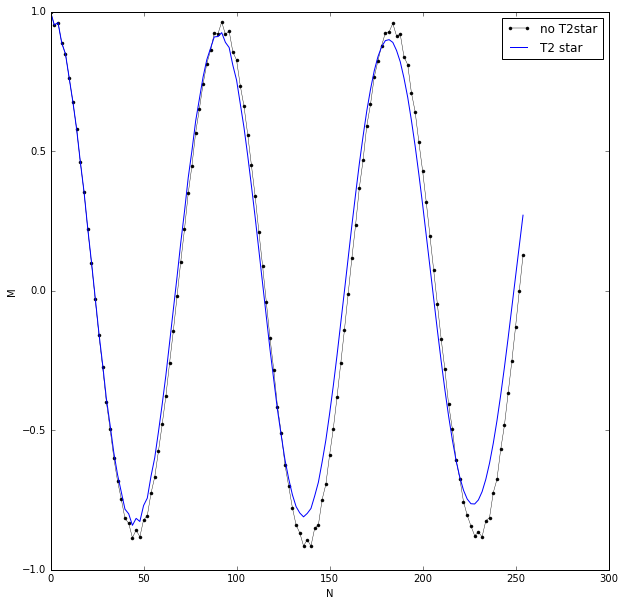

In [14]:
plt.figure(figsize = (10,10))
plt.plot(N_vals, N_data_orig, '.-k', lw=0.4, label = 'no T2star')
plt.plot(N_vals, N_data_T2star, label = 'T2 star')
plt.xlabel('N')
plt.ylabel('M')
plt.legend()
plt.show()

In [15]:
def calc_M_single_T2star(A, B, N, omega_larmor, tau, omega_stddev, num_iters = 100):
    M_list = []
    for i in range(num_iters):
        omega_larmor_sample = np.random.normal(loc = omega_larmor, scale = omega_stddev)
        M_list.append(analysis.calc_M_single(A, B, N, omega_larmor_sample, tau))
    return np.mean(M_list, axis=0)

def calc_M_T2star(A_list, B_list, N, omega_larmor, tau, omega_stddev_list, num_iters = 100):
    return reduce(lambda accum, next: accum * calc_M_single_T2star(next[0], next[1], N, omega_larmor, tau, next[2], num_iters = num_iters),
                  zip(A_list, B_list, omega_stddev_list), 1.0)

In [16]:
N_vals = np.arange(0,256,2)
res_tau = tau[dip_inds[dii]]
N_data_orig = analysis.calc_M(As, Bs, N_vals, omega_larmor, res_tau)
N_data_T2star = calc_M_T2star(As, Bs, N_vals, omega_larmor, res_tau, len(As) * [omega_stddev], num_iters = 1000)

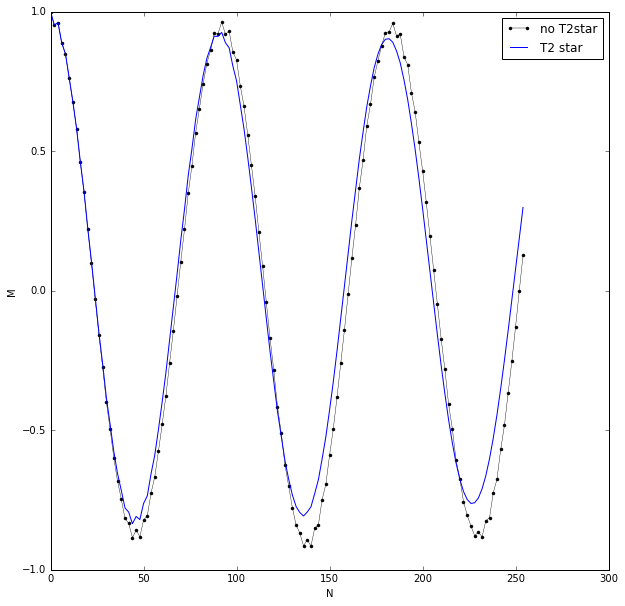

In [17]:
plt.figure(figsize = (10,10))
plt.plot(N_vals, N_data_orig, '.-k', lw=0.4, label = 'no T2star')
plt.plot(N_vals, N_data_T2star, label = 'T2 star')
plt.xlabel('N')
plt.ylabel('M')
plt.legend()
plt.show()

### It is still a product of functions one for each spin! (Assuming that the omega values are independent random variables for each spin). Let's just look at a single spin at a time then

In [65]:
N_vals = np.arange(0,256,2)
res_tau = tau[dip_inds[dii]]
ind = 0
omega_stddev = np.sqrt(2)/(1e-3)
N_data_orig = analysis.calc_M_single(As[ind], Bs[ind], N_vals, omega_larmor, res_tau)
N_data_T2star = calc_M_single_T2star(As[ind], Bs[ind], N_vals, omega_larmor, res_tau, omega_stddev, num_iters = 10 ** 5)

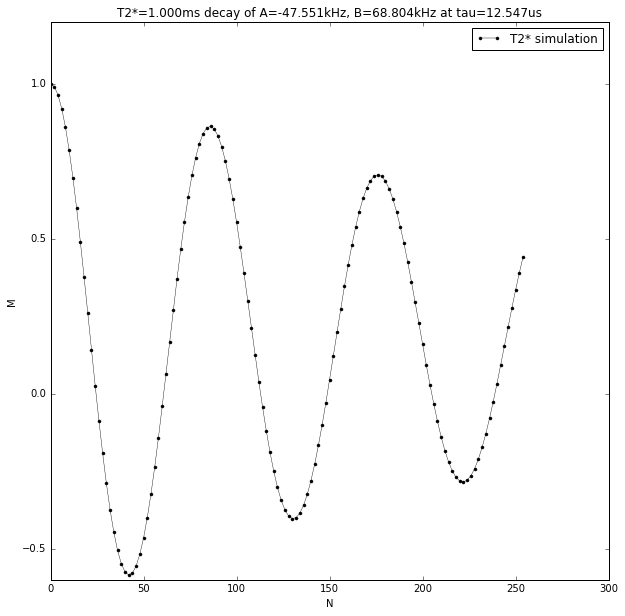

In [66]:
plt.figure(figsize = (10,10))
#plt.plot(N_vals, N_data_orig, '.-k', lw=0.4, label = 'no T2star')
plt.plot(N_vals, N_data_T2star, '.-k', lw=0.4, label = 'T2* simulation')
plt.xlabel('N')
plt.ylabel('M')
plt.title("T2*=" + '%.3f'%(np.sqrt(2)/omega_stddev * 1e3) + "ms decay of A=" +
          '%.3f'%(As[ind]/analysis.mag) + "kHz, B=" + '%.3f'%(Bs[ind]/analysis.mag) 
          + "kHz at tau=" + '%.3f'%(res_tau * 1e6) + "us")
plt.legend()
#plt.savefig(figures_path + "T2star_decay_N_" + str(N_vals[-1]) + ".png")
plt.show()

In [67]:
power = 2
def T2_decay_fit_fun_single(N, phi, x, T):
    return 1 - .5 * x + .5 * x * np.exp(-(N/T) ** power) * np.cos(N * phi)

In [68]:
param_guess = [phis[ind], xs[ind], 700]
popts, pcovs = opt.curve_fit(T2_decay_fit_fun_single, N_vals, N_data_T2star, p0 = param_guess)

In [69]:
popts, phis[ind], xs[ind]

(array([  7.13876499e-02,   1.62560442e+00,  -2.69895511e+02]),
 0.068408439217210779,
 1.9264783915608326)

In [71]:
(np.sqrt(2)/(1e-3)) * 1e3, popts[2] * 2 * tau[dip_inds[dii]] * 1e3

(1414213.5623730952, -6.7725300289189727)

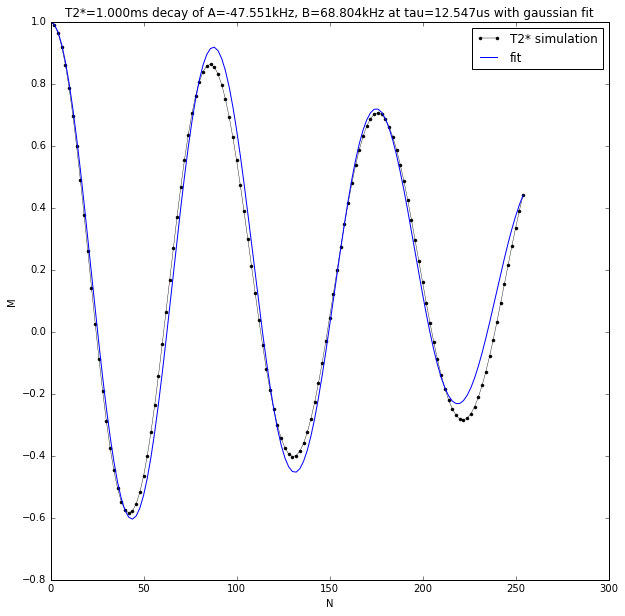

In [72]:
plt.figure(figsize = (10,10))
plt.plot(N_vals, N_data_T2star, '.-k', lw=0.4, label = 'T2* simulation')
plt.plot(N_vals, T2_decay_fit_fun_single(N_vals, *popts), label = 'fit')
plt.xlabel('N')
plt.ylabel('M')
plt.legend()
plt.title("T2*=" + '%.3f'%(np.sqrt(2)/omega_stddev * 1e3) + "ms decay of A=" +
          '%.3f'%(As[ind]/analysis.mag) + "kHz, B=" + '%.3f'%(Bs[ind]/analysis.mag) 
          + "kHz at tau=" + '%.3f'%(tau[dip_inds[dii]] * 1e6) + "us" + " with gaussian fit")
#plt.savefig(figures_path + "T2star_decay_N_" + str(N_vals[-1]) + "_fit.png")
plt.show()

In [30]:
T2star_list = np.linspace(1e-3, 50e-3, 100)
omega_stddev_list = np.sqrt(2)/T2star_list
N_vals = np.arange(0,256,2)
res_tau = tau[dip_inds[dii]]
ind = 0
popts_list = []
for omega_stddev in omega_stddev_list:
    N_data_T2star = calc_M_single_T2star(As[ind], Bs[ind], N_vals, omega_larmor, res_tau, omega_stddev, num_iters = 10 ** 4)
    param_guess = [phis[ind], xs[ind], 700]
    popts, pcovs = opt.curve_fit(T2_decay_fit_fun_single, N_vals, N_data_T2star, p0 = param_guess)
    popts_list.append(popts)

In [32]:
T_list = np.array([popts[2] for popts in popts_list])
slope, intercept, _, _, _ = stats.linregress(T2star_list,T_list * 2 * res_tau)
print slope, intercept

8.24708321203 -0.00219522371775


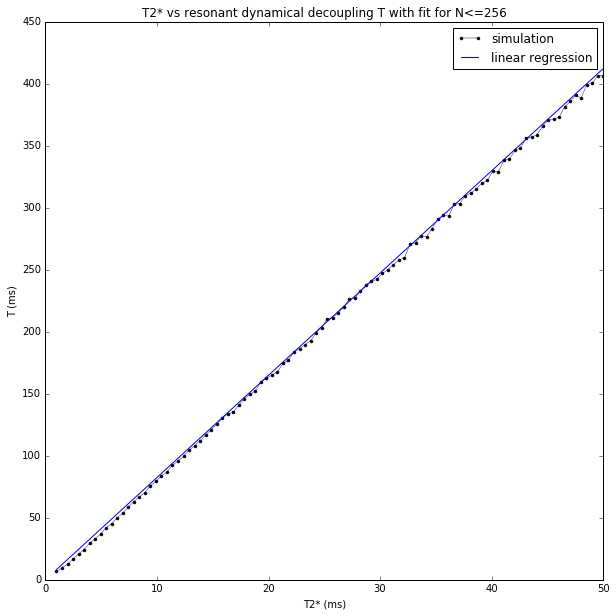

In [34]:
plt.figure(figsize = (10,10))
plt.plot(T2star_list*1e3,T_list * 2 * res_tau * 1e3, '.-k', lw=0.4, label = 'simulation')
plt.plot(T2star_list*1e3, T2star_list*1e3 * slope + intercept, label = 'linear regression')
plt.xlabel('T2* (ms)')
plt.ylabel('T (ms)')
plt.legend()
plt.title("T2* vs resonant dynamical decoupling T with fit for N<=256")
plt.savefig(figures_path + "T2star_vs_T_256_fit.png")
plt.show()

In [565]:
A, B = As[ind], Bs[ind]
res_tau = tau[dip_inds[dii]]
def terms(omega_larmor):
    omega_tilde = np.sqrt((A + omega_larmor) ** 2 + B ** 2)
    mx = B/omega_tilde
    mz = (A+omega_larmor)/omega_tilde
    alpha = omega_tilde * res_tau
    beta = omega_larmor * res_tau
    cosphi = np.cos(alpha) * np.cos(beta)- mz * np.sin(alpha) * np.sin(beta)
    vec_num = (mx ** 2) * (1-np.cos(alpha)) * (1-np.cos(beta))
    vec_denom = 1.0 + cosphi
    for i in np.where(vec_denom == 0.0)[0]:
        vec_denom[i] = .0001
    vec_term = vec_num/vec_denom
    x = vec_num/vec_denom
    phi = np.arccos(cosphi)
    return phi, cosphi, np.sin(phi), alpha + beta, np.cos(alpha+beta), np.sin(alpha+beta), x
phi, cosphi, sinphi, ab, cosab, sinab, x = terms(omega_larmor)
print phi, cosphi, sinphi, ab, cosab, sinab, x

3.07315021051 -0.997658730154 0.0683890206611 4.13601133549 -0.544990383233 -0.838442295083 1.93034848751


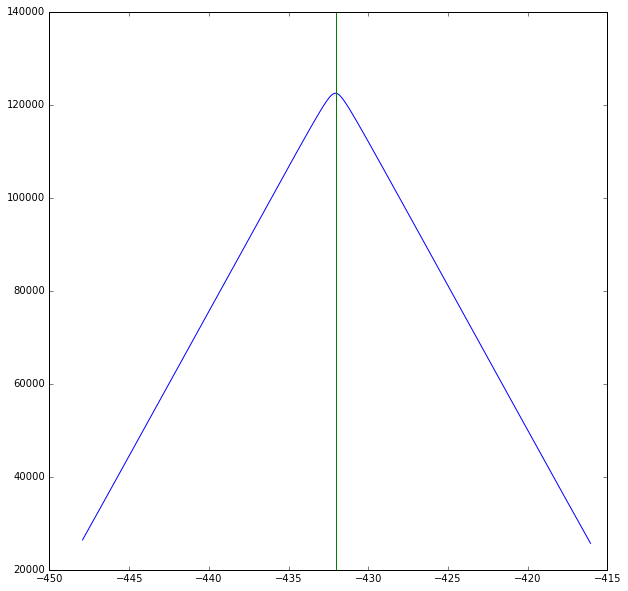

In [585]:
omegas = np.linspace(omega_larmor-100e3, omega_larmor+100e3 + 200, 10000)
phis, cosphis, sinphis, ab, cosabs, sinabs, xs = terms(omegas)
plt.figure(figsize = (10,10))
#plt.plot(omegas/analysis.mag, cosphis)
plt.plot(omegas/analysis.mag, phis/(2 * res_tau))
#plt.plot(omegas/analysis.mag, sinabs)
#plt.plot(omegas/analysis.mag, np.gradient(phis/(2 * res_tau), omegas[1] - omegas[0]))
#plt.plot(omegas/analysis.mag, xs)
#plt.plot(omegas/analysis.mag, np.gradient(xs, omegas[1]-omegas[0]))
plt.axvline(omega_larmor/analysis.mag, c='green')

In [228]:
def T2_decay_fit_fun(N, *args):
    num_spins = len(args)/3
    phis, xs, Ts = args[:num_spins], args[num_spins:2*num_spins], args[2 * num_spins:3*num_spins]
    return reduce(lambda accum, next: accum * T2_decay_fit_fun_single(N, next[0], next[1], next[2]), zip(phis, xs, Ts), 1.0)

In [237]:
def data_func_T2star(N, tau, noise_level = .02, omega_stddev_list = None): #put the noise at .02
    if omega_stddev_list == None:
        omega_stddev_list = len(diamond["A"]) * [200]
    data = calc_M_T2star(diamond["A"], diamond["B"], N, omega_larmor, tau, omega_stddev_list)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise

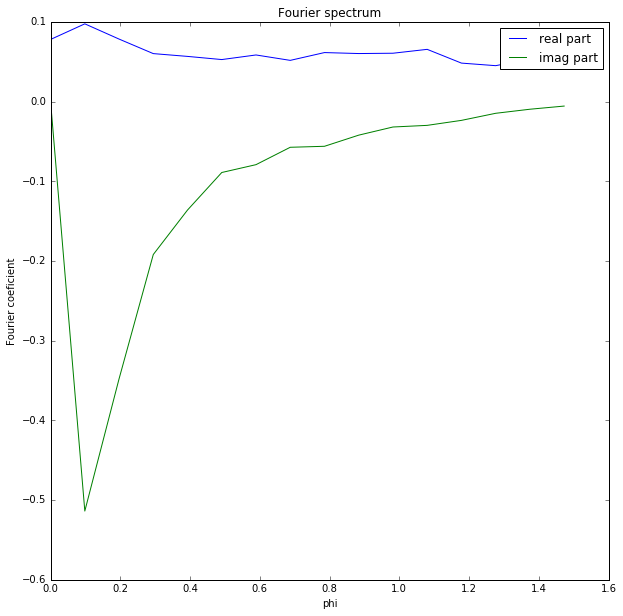

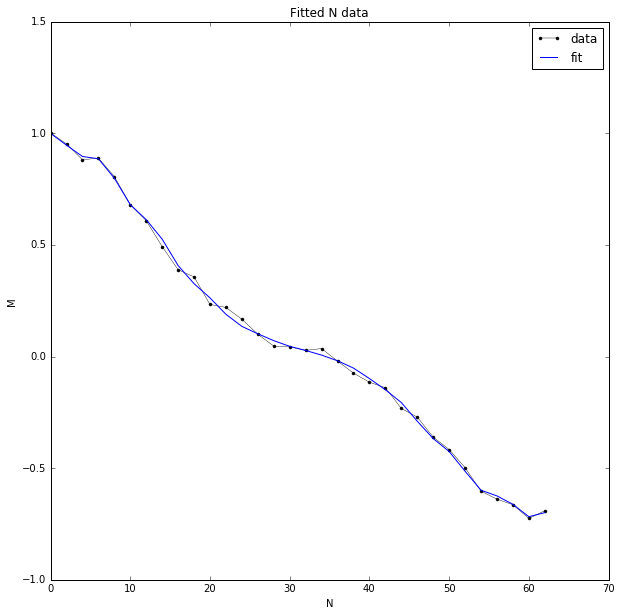

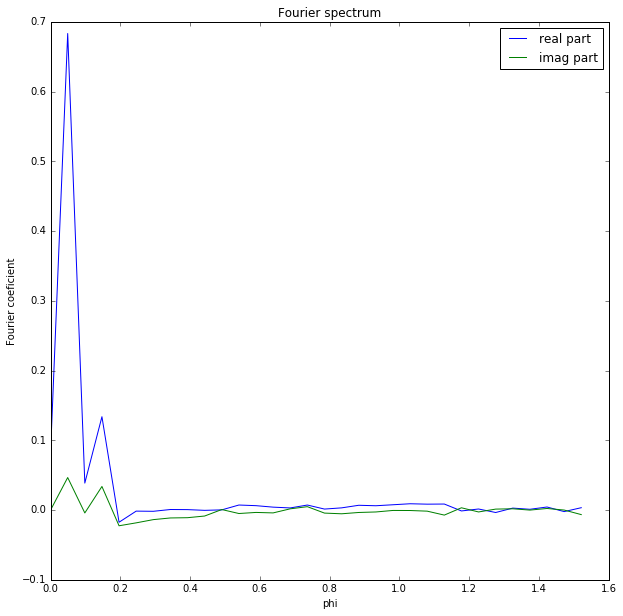

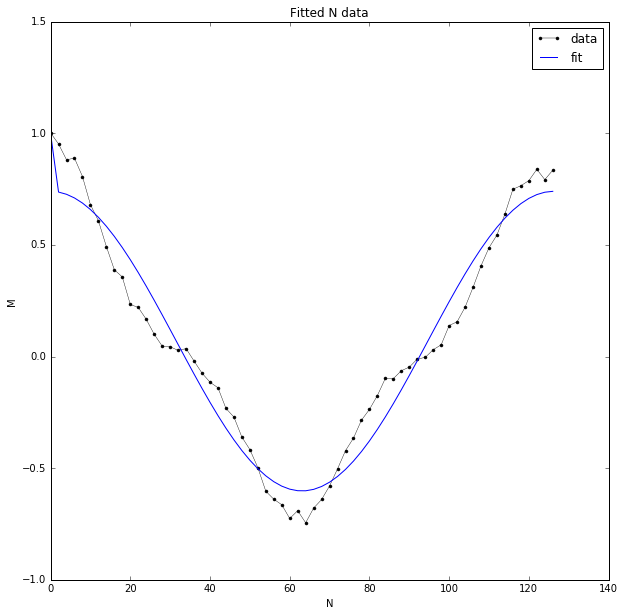

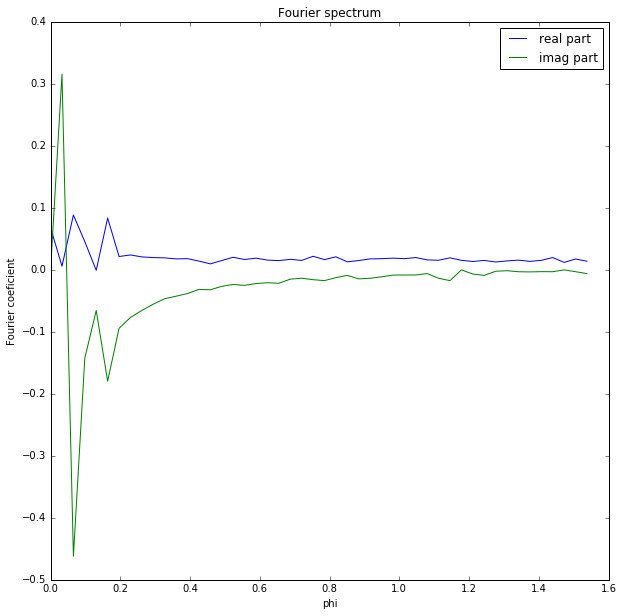

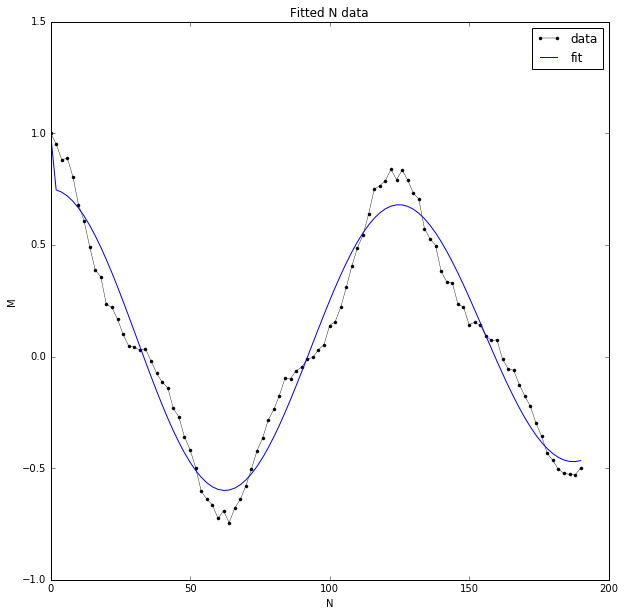

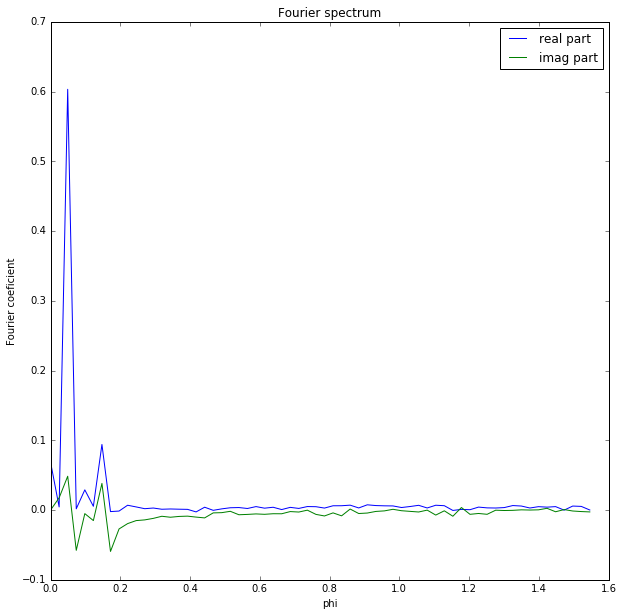

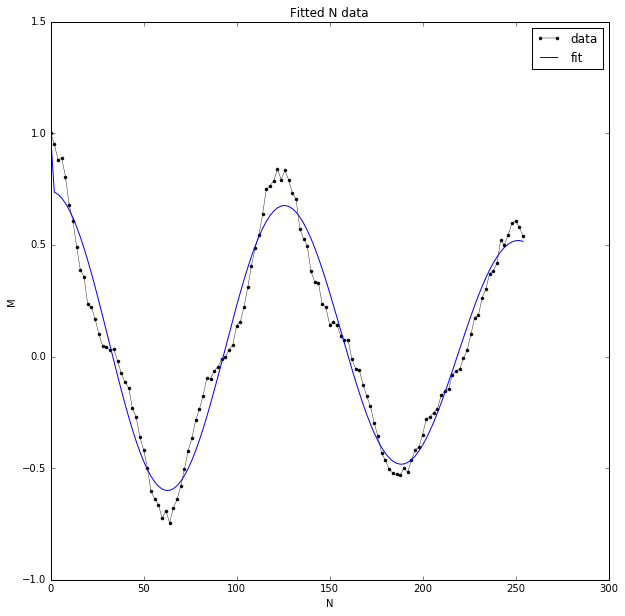

best:  3
res_tau:  1.77185722691e-05
scaled_error <= error_tol:  False
scaled_error:  0.00842651772293
xs, phis, scaled_error:  [ 1.83280993  0.519328  ] [ 0.04974321  1.51844741] 0.00842651772293


In [238]:
dii = 100
spin_dict = {}
spin_dict = analysis.analyze_dip(dip_inds[dii], tau, data_func_T2star, omega_larmor, spin_dict, N_vals = np.arange(0,256,2),
            error_tol = .1/64, fit_fun = T2_decay_fit_fun, extra_params = 4 * [200], verbose = True, plots = True)

In [232]:
xs, phis

([0.042906319589573451,
  1.8303675536042652,
  0.038663217560594168,
  0.752202821376872],
 [0.056742387596575614,
  0.048568030574286242,
  1.3077823149422747,
  0.10498723931111446])

In [290]:
N_vals = np.arange(0,2000,2)
res_tau = 4.932 * 1e-6
A = -48.7 * analysis.mag
B = 12 * analysis.mag
T2 = 4.5 * 1e-3
omega_stddev = np.sqrt(2)/T2
N_data_orig = analysis.calc_M_single(A, B, N_vals, omega_larmor, res_tau)
N_data_T2star = calc_M_single_T2star(A, B, N_vals, omega_larmor, res_tau, omega_stddev, num_iters = 1000)

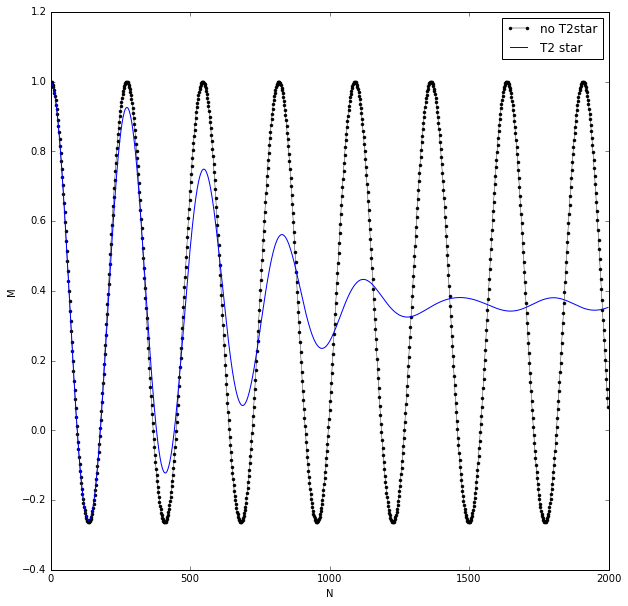

In [291]:
plt.figure(figsize = (10,10))
plt.plot(N_vals, N_data_orig, '.-k', lw=0.4, label = 'no T2star')
plt.plot(N_vals, N_data_T2star, label = 'T2 star')
plt.xlabel('N')
plt.ylabel('M')
plt.legend()
plt.show()

In [279]:
omega_stddev

217.57131728816847

In [281]:
B

345575.19189487724